In [1]:
! pip install torch==2.2.1
! pip install torchvision==0.17.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 895.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Import required libraries

In [2]:
import os
import time
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import pandas as pd


import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, default_collate, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 2. Define necessary functions
## 2.1 Make train and test dataset

In [3]:
def make_ds(dataset_dir, filtered_dataset_dir, selected_classes):
    if not os.path.exists(filtered_dataset_dir):
        os.makedirs(filtered_dataset_dir)
    
    for class_name in selected_classes:
        src = os.path.join(dataset_dir, class_name)
        dst = os.path.join(filtered_dataset_dir, class_name)
        
        if os.path.exists(src):
            if not os.path.exists(dst):
                os.makedirs(dst)

            image_files = [f for f in os.listdir(src) if os.path.isfile(os.path.join(src, f))]

            for image in image_files:
                try:
                    shutil.copy2(os.path.join(src, image), os.path.join(dst, image))
                except Exception as e:
                    print(f"Error copying {image}: {e}")

        else:
            print(f"Source directory {src} does not exist. Skipping...")

    print(f"Data is copied to {filtered_dataset_dir}")

## 2.2 Test the model

In [4]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = correct / total
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    cr = metrics.classification_report(y_true, y_pred)

    return test_accuracy, cm, cr

## 2.3 Display images

In [5]:
def display_img(images, labels):
    cols = 8
    rows = (images.shape[0] // cols) + (1 if images.shape[0] % cols != 0 else 0)

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
    for i in range(images.shape[0]):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        ax.imshow(img)
        ax.axis('off') 
        ax.set_title(f"Label: {labels[i]}")

    # Hide any empty subplots
    for j in range(images.shape[0], rows * cols):
        if rows > 1:
            axes[j // cols, j % cols].axis('off')
        else:
            axes[j % cols].axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()

## 2.4 Display Confusion HeatMap

In [6]:
def confusion_matrix_heatmap(confusion_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

# 3. Load the Dataset
## 3.1 Make the dataset

In [7]:
dataset_dir = "/kaggle/input/adhils-plant-disease-train-dataset-v2/data"
test_dir = "/kaggle/input/adhils-plant-diseases-test-dataset/data"
filtered_train_dir = '/kaggle/working/data/train'
filtered_test_dir = '/kaggle/working/data/test'

classes = ['Apple___healthy', 'Apple___rust', 'Bell_pepper___bacterial_spot', 
           'Bell_pepper___healthy', 'Tomato___septoria_leaf_spot', 'Tomato___healthy',
          'Grape___black_rot', 'Grape___healthy']

make_ds(dataset_dir, filtered_train_dir, classes)
make_ds(test_dir, filtered_test_dir, classes)

Data is copied to /kaggle/working/data/train
Data is copied to /kaggle/working/data/test


## 3.2 Define necessary parameters

In [8]:
NUM_CLASSES = 8
BATCH_SIZE = 32
TRAINING_SPLIT = 0.7
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
LR = 0.01

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
preproc = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32)
])

In [11]:
dataset = datasets.ImageFolder(filtered_train_dir, transform=preproc)

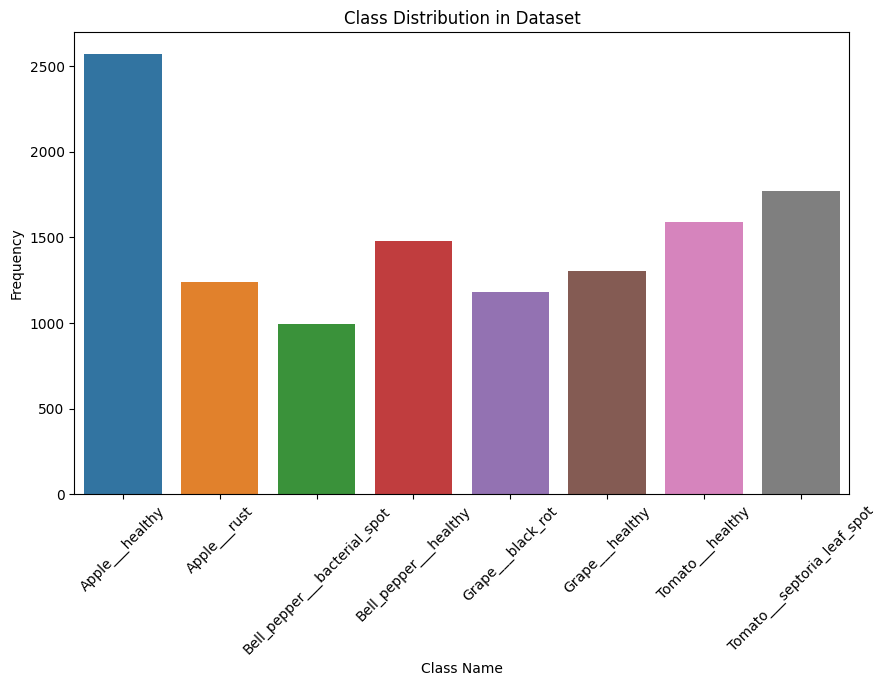

In [12]:
targets = [sample[1] for sample in dataset.samples]
targets_tensor = torch.tensor(targets)

sample_freq = torch.unique(targets_tensor, return_counts=True)
class_labels, counts = sample_freq

class_names = [dataset.classes[label] for label in class_labels.numpy()]

df = pd.DataFrame({'Class': class_names, 'Count': counts.numpy()})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=df)
plt.xlabel('Class Name')
plt.ylabel('Frequency')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()


In [13]:
dataset_length = len(dataset)
train_length = int(dataset_length * TRAINING_SPLIT)
val_length = int(dataset_length * VALIDATION_SPLIT)
test_length = dataset_length - train_length - val_length  
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_length, val_length, test_length])

## 3.3 Cutmix Augmentation

In [14]:
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
def cutmix_fn(batch):
    return cutmix(*default_collate(batch))

## 3.4 Assign Weights to Address Class Imbalance
wj=n_samples / (n_classes * n_samplesj)

In [15]:
class_counts = [len([label for _, label in dataset.samples if label == i]) for i in range(NUM_CLASSES)]
class_weights = [train_length / (NUM_CLASSES*count) for count in class_counts]
class_weights = torch.tensor(class_weights).to(device)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=cutmix_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

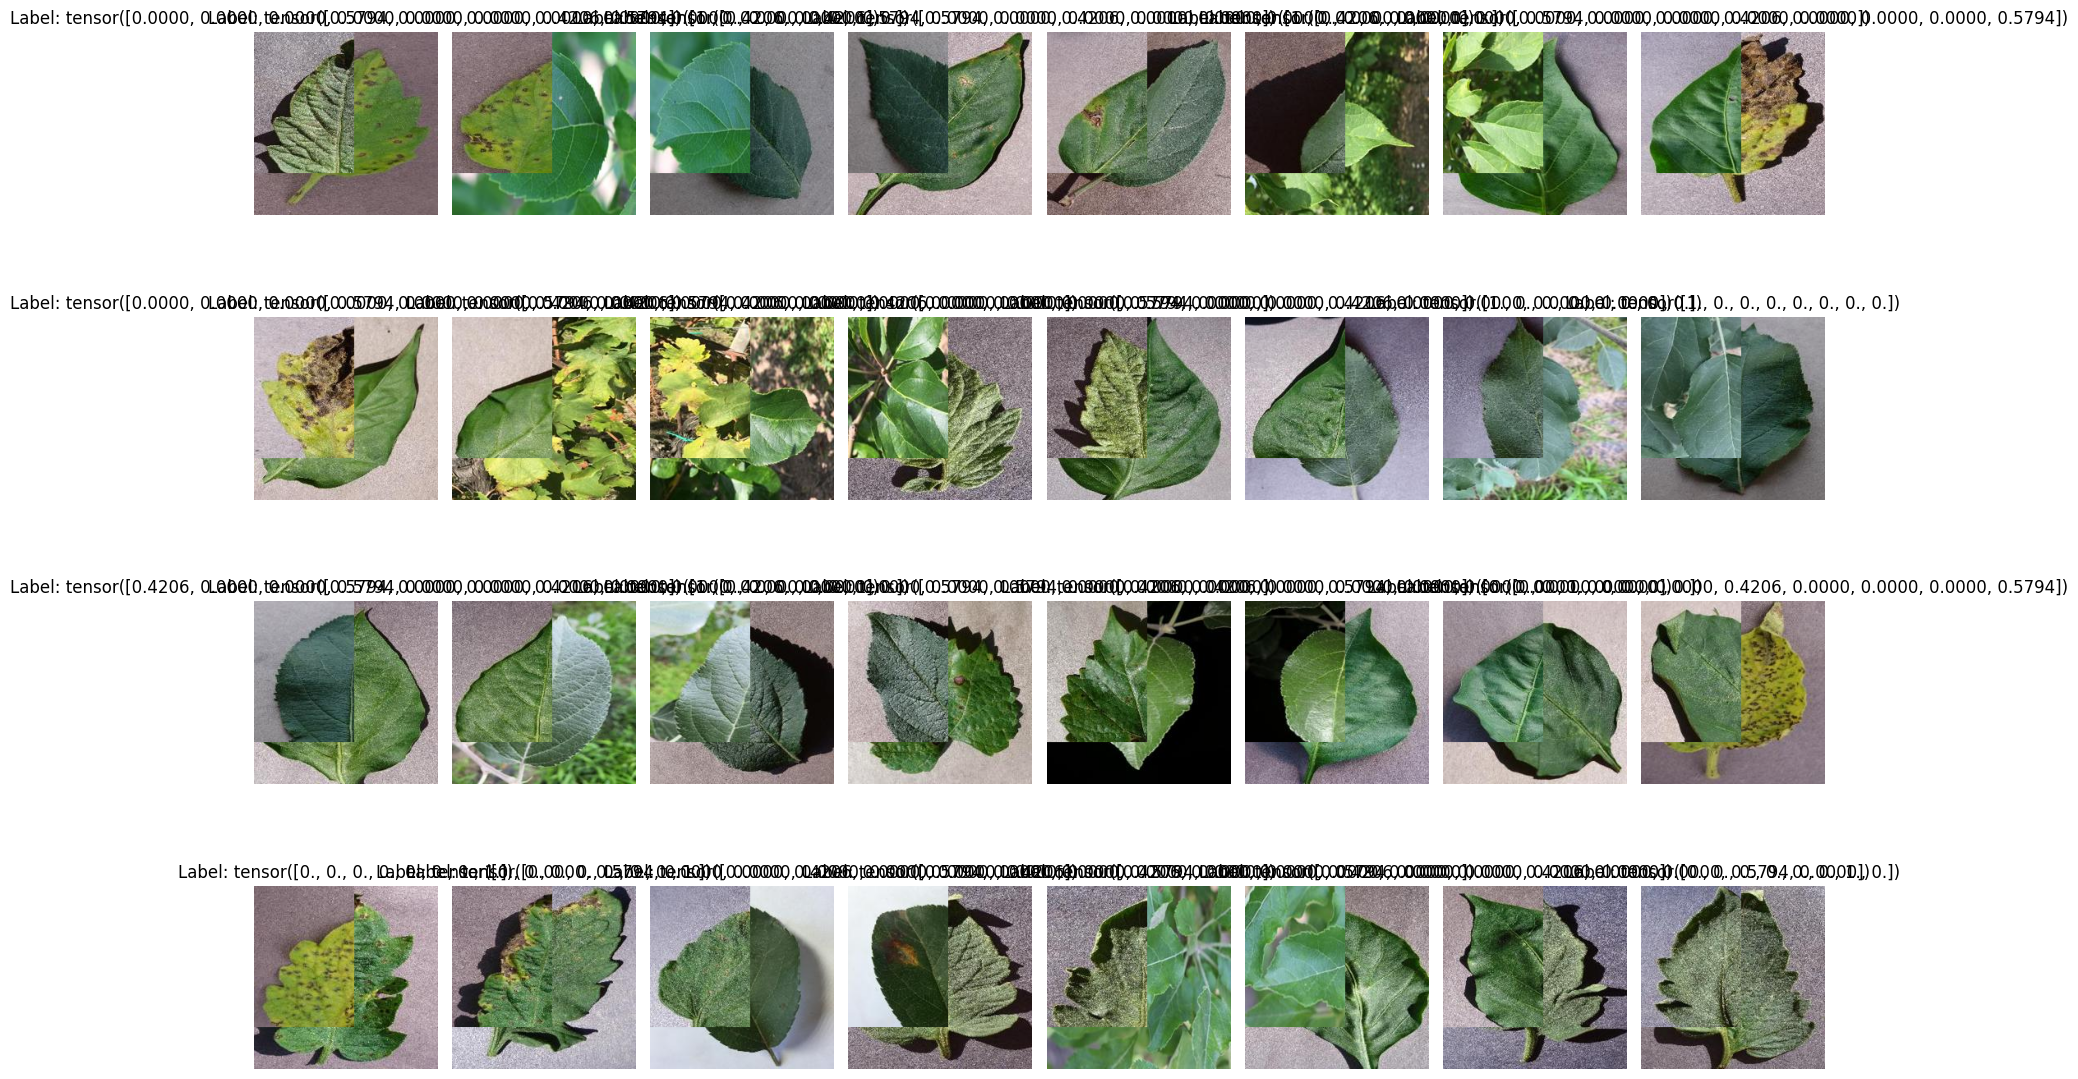

In [17]:
images, labels = next(iter(train_loader))
display_img(images, labels)

# 4. Define the Model
## 4.1 Define the Model

In [18]:
import torchvision.models as models
base_model = models.convnext_tiny(pretrained=True)

# Remove the top layers to keep only the feature extractor
base_model = nn.Sequential(*list(base_model.children())[:-1])

# Move the base model to the device
base_model = base_model.to(device)

# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze the last four layers
for param in list(base_model.parameters())[-4:]:
    param.requires_grad = True

# Define the custom model with additional layers
class CustomModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.flatten = nn.Flatten()  # Ensure correct flattening
        
        # Define the correct input size for fc1
        in_features = 768  # EfficientNetB0 output size
        self.fc1 = nn.Linear(in_features, 512)  
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, num_classes)  # Ensure this matches `num_classes`

    def forward(self, x):
        x = self.base_model(x)  # Apply the base model
        x = self.global_avg_pool(x)  # Global Average Pooling
        x = self.flatten(x)  # Ensure correct flattening
        x = F.relu(self.fc1(x))  # ReLU activation
        x = self.dropout1(x)  # Dropout
        x = F.relu(self.fc2(x))  # ReLU activation
        x = self.dropout2(x)  # Dropout
        x = F.relu(self.fc3(x))  # ReLU activation
        x = self.dropout3(x)  # Dropout
        x = F.softmax(self.fc4(x), dim=1)  # Softmax for classification
        return x

# Initialize the custom model with the correct input size
model = CustomModel(base_model, NUM_CLASSES)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 150MB/s] 


## 4.2 EarlyStopping Critaria

In [19]:
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

from copy import deepcopy
# 5. Learning rate decay: ReduceLROnPlateau (reduce on a plateau of validation loss)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

# 6. Early stopping: Implement an early stopping callback
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = deepcopy(model.state_dict())

## 4.3 Define Loss function

In [20]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 5. Training

In [21]:
# 7. Training loop with learning rate decay and early stopping
num_epochs = 50 # Increase the number of epochs
early_stopping = EarlyStopping(patience=5, delta=0.01)  # Instantiate the early stopping callback

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to the correct device

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets) 
        loss.backward() 
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1) 

        if targets.ndimension() == 2 and targets.size(1) > 1:
            true_labels = torch.argmax(targets, dim=1)
        else:
            true_labels = targets

        correct += (predicted == true_labels).sum().item()  
        total += targets.size(0)

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch} - Train Accuracy: {train_accuracy:.3f}, Train Loss: {train_loss / len(train_loader):.3f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to the correct device

            outputs = model(inputs)

            loss = criterion(outputs, targets)  
            val_loss += loss.item()

            _, predicted = outputs.max(1)

            if targets.ndimension() == 2 and targets.size(1) > 1:
                true_labels = torch.argmax(targets, dim=1)  
            else:
                true_labels = targets  

            correct += (predicted == true_labels).sum().item() 
            total += targets.size(0)

        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Accuracy: {val_accuracy:.3f}, Validation Loss: {val_loss / len(val_loader):.3f}")

        early_stopping(val_loss, model)

        if early_stopping.stop:
            print("Early stopping triggered")
            break

    lr_scheduler.step(val_loss)

if early_stopping.stop:
    model.load_state_dict(early_stopping.best_model)
    print("Loaded the best model weights")

Epoch 1 - Train Accuracy: 0.117, Train Loss: 1.457
Validation Accuracy: 0.123, Validation Loss: 2.079
Epoch 2 - Train Accuracy: 0.123, Train Loss: 1.456
Validation Accuracy: 0.123, Validation Loss: 2.079
Epoch 3 - Train Accuracy: 0.125, Train Loss: 1.456
Validation Accuracy: 0.123, Validation Loss: 2.079
Epoch 4 - Train Accuracy: 0.126, Train Loss: 1.456
Validation Accuracy: 0.123, Validation Loss: 2.078
Epoch 5 - Train Accuracy: 0.125, Train Loss: 1.456
Validation Accuracy: 0.123, Validation Loss: 2.078
Epoch 6 - Train Accuracy: 0.125, Train Loss: 1.455
Validation Accuracy: 0.123, Validation Loss: 2.077
Epoch 7 - Train Accuracy: 0.125, Train Loss: 1.455
Validation Accuracy: 0.123, Validation Loss: 2.075
Epoch 8 - Train Accuracy: 0.125, Train Loss: 1.454
Validation Accuracy: 0.123, Validation Loss: 2.071
Epoch 9 - Train Accuracy: 0.142, Train Loss: 1.450
Validation Accuracy: 0.205, Validation Loss: 2.051
Epoch 10 - Train Accuracy: 0.200, Train Loss: 1.427
Validation Accuracy: 0.229, Va

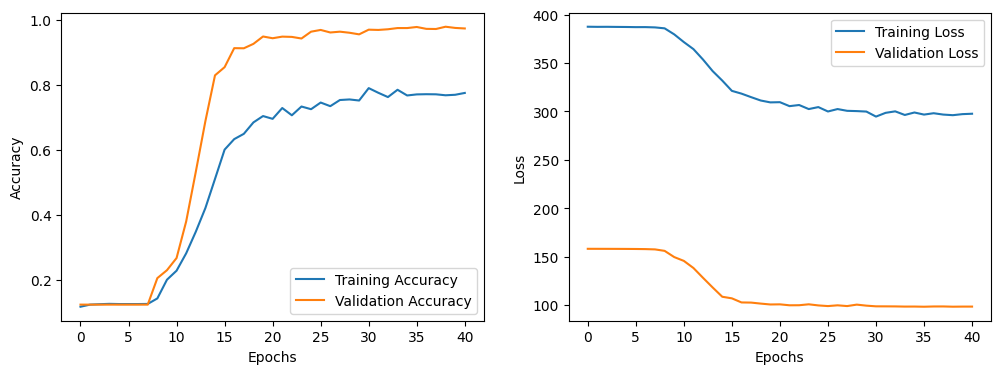

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 5.1 Validation Accuracy

In [23]:
test_accuracy, confusion_matrix, classification_report = test_model(model, val_loader, device)
print(f"Test Accuracy: {val_accuracy:.3f}")

Test Accuracy: 0.973


In [24]:
print(classification_report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       523
           1       0.89      0.94      0.91       216
           2       0.99      1.00      0.99       204
           3       1.00      0.99      0.99       299
           4       1.00      1.00      1.00       244
           5       0.99      1.00      0.99       264
           6       0.98      1.00      0.99       333
           7       1.00      0.97      0.98       343

    accuracy                           0.98      2426
   macro avg       0.98      0.98      0.98      2426
weighted avg       0.98      0.98      0.98      2426



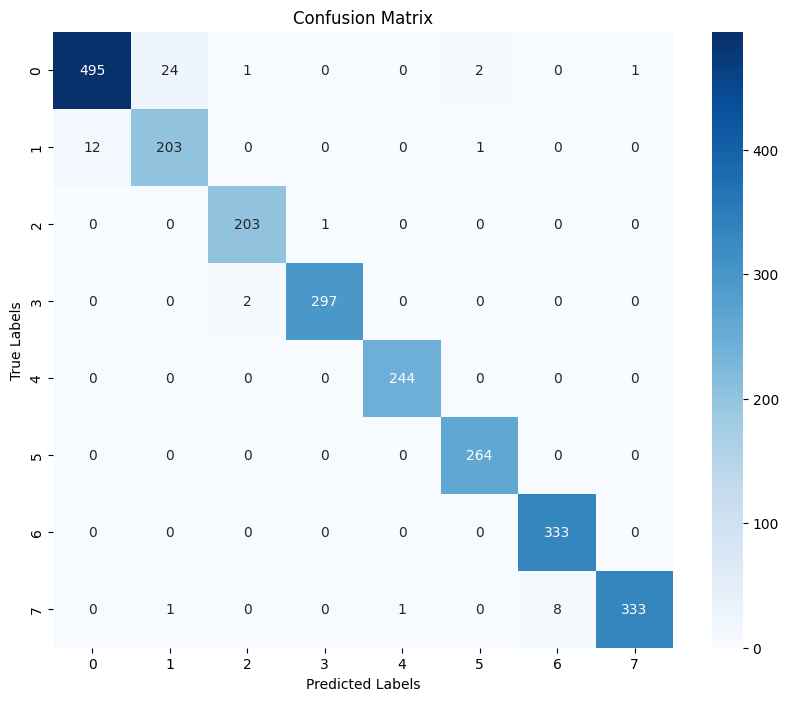

In [25]:
confusion_matrix_heatmap(confusion_matrix)

# 6. Testing the model with 10% Test portion

In [26]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [27]:
test_accuracy, confusion_matrix, classification_report = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.978


In [28]:
print(classification_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       252
           1       0.92      0.94      0.93       126
           2       0.98      0.97      0.97        97
           3       0.97      0.98      0.98       117
           4       1.00      1.00      1.00       131
           5       0.98      1.00      0.99       130
           6       0.99      1.00      0.99       154
           7       1.00      0.99      0.99       207

    accuracy                           0.98      1214
   macro avg       0.98      0.98      0.98      1214
weighted avg       0.98      0.98      0.98      1214



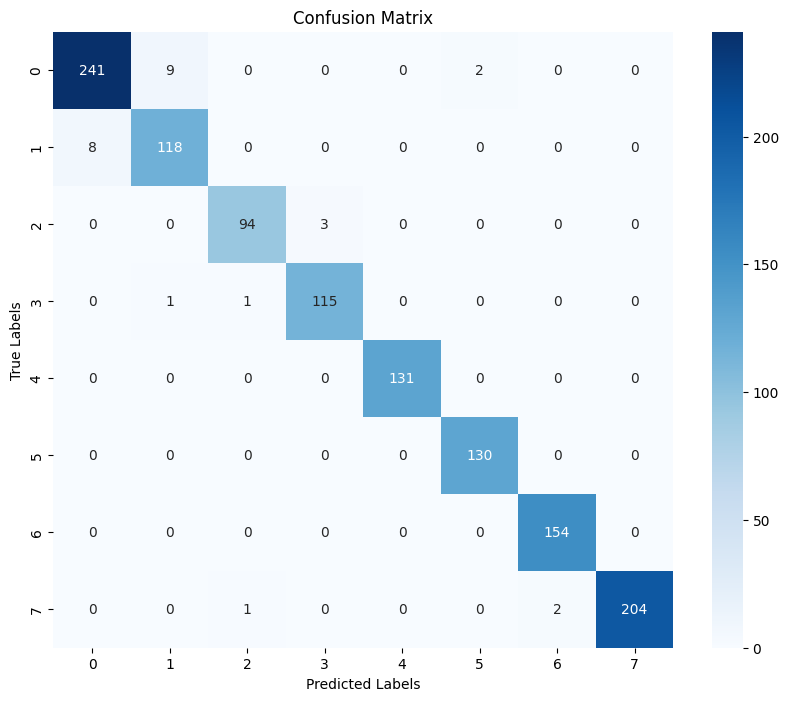

In [29]:
confusion_matrix_heatmap(confusion_matrix)

# 7. Testing the model with Test Dataset

In [30]:
dataset = datasets.ImageFolder(filtered_test_dir, transform=preproc)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
test_accuracy, confusion_matrix, classification_report = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.745


In [32]:
print(classification_report)

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       135
           1       0.30      0.70      0.42        82
           2       0.53      0.15      0.24        65
           3       0.45      0.15      0.22        61
           4       0.98      0.90      0.94       461
           5       0.89      0.96      0.92       469
           6       0.22      0.06      0.10        63
           7       0.35      0.18      0.24        49

    accuracy                           0.75      1385
   macro avg       0.52      0.46      0.45      1385
weighted avg       0.75      0.75      0.73      1385



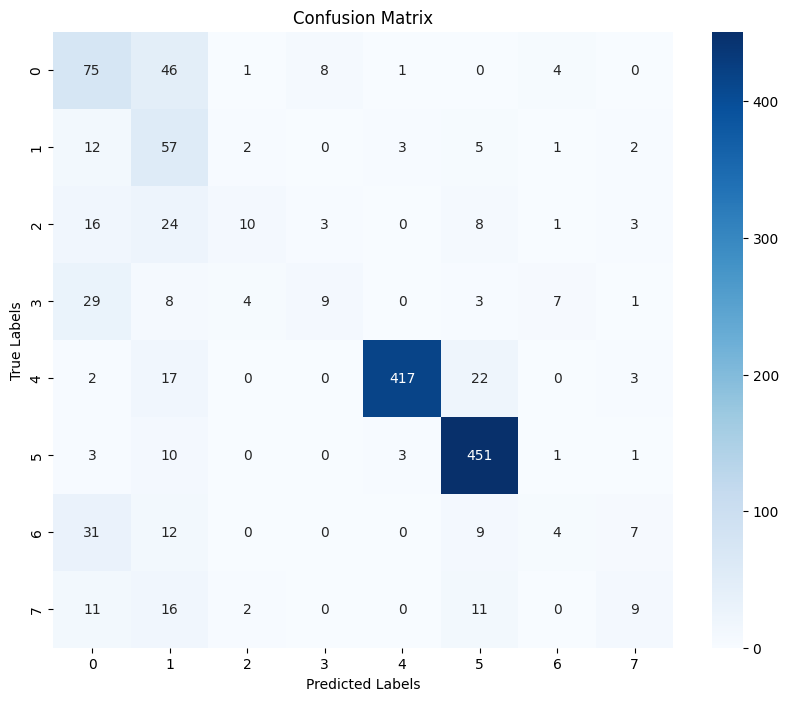

In [33]:
confusion_matrix_heatmap(confusion_matrix)